In [137]:
import numpy as np

In [138]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = [12,12]
def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))

In [139]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def animate_trajectory(t1, t2, t3, t4):
    fig, ax = plt.subplots()
    n = len(t1)
    def step(t):
        ax.cla()
        ax.plot([3.0 / 2], [35.0 / 22], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-3, 5, delta)
        y = np.arange(-3, 5, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [1, 3, 6], colors=['blue', 'purple', 'red'])

        ax.plot([u[0] for u in t1[:t]], [u[1] for u in t1[:t]], color='black', label='opt')
        ax.plot([u[0] for u in t1[:t]], [u[1] for u in t1[:t]], 'o', color='black')
        
        ax.plot([u[0] for u in t2[:t]], [u[1] for u in t2[:t]], color='purple', label='nesterov')
        ax.plot([u[0] for u in t2[:t]], [u[1] for u in t2[:t]], 'o', color='purple')
        
        ax.plot([u[0] for u in t3[:t]], [u[1] for u in t3[:t]], color='orange', label='chebyshev')
        ax.plot([u[0] for u in t3[:t]], [u[1] for u in t3[:t]], 'o', color='orange')
        
        ax.plot([u[0] for u in t4[:t]], [u[1] for u in t4[:t]], color='blue', label='ball')
        ax.plot([u[0] for u in t4[:t]], [u[1] for u in t4[:t]], 'o', color='blue')
        
        fix_scaling(ax)
        ax.axis('off')
    plt.close()
    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)

In [140]:
a = 1 # A
b = 11 # K
start_point = np.array([2, 2.8])
steps_num = 30
def func(x):
    return a * x[0] ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]

def f_grad(x):
    return np.array([2 * a * x[0] + 2 * b * (x[0] - x[1]) - 1, 2 * b * (x[1] - x[0]) - 2])

def f_grad2():
    return np.matrix([[2 * a + 2 * b, -2 * b], [-2 * b, 2 * b]])

def f_grad2_numbers():
    return np.linalg.eig(f_grad2())[0]

In [141]:
#optimal step
alpha = 2.0 / (sum(list(f_grad2_numbers())))
traj_opt_step = []
x_start = start_point
traj_opt_step.append(x_start.copy())
cur_x = x_start.copy()
for i in range(steps_num):
    cur_x = cur_x - alpha * f_grad(cur_x)
    traj_opt_step.append(cur_x.copy()) 

In [142]:
#optimal step
print(traj_opt_step[-1])

[1.635913   1.91957144]


In [143]:
#chebychev
lambdas = list(f_grad2_numbers())
phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
cur_gamma = 1.0 / phi
prev_gamma = 0
traj_chebyshev = []
x_start = start_point
traj_chebyshev.append(x_start.copy())
cur_x = x_start.copy()
prev_x = x_start.copy()
for i in range(steps_num):
    t = cur_x
    alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
    beta = cur_gamma * prev_gamma
    cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
    prev_x = t
    t = cur_gamma
    cur_gamma = 1.0 / (2 * phi - cur_gamma)
    prev_gamma = t
    traj_chebyshev.append(cur_x.copy())

In [144]:
#chebychev
print(traj_chebyshev[-1])

[1.49412682 1.59636965]


In [145]:
#heavy ball
alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
traj_heavy_ball = []
x_start = start_point
traj_heavy_ball.append(x_start.copy())
cur_x = x_start.copy()
prev_x = x_start.copy()
for i in range(steps_num):
    t = cur_x
    cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
    prev_x = t
    traj_heavy_ball.append(cur_x.copy())

In [146]:
#heavy ball
print(traj_heavy_ball[-1])

[1.51060954 1.60166044]


In [147]:
#nesterov
alpha = 1 / (lambdas[0] + 1)
beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
traj_nesterov = []
x_start = start_point
traj_nesterov.append(x_start.copy())
cur_x = x_start.copy()
cur_y = x_start.copy()

for i in range(steps_num):
    t = cur_x
    cur_x = cur_y - alpha * f_grad(cur_y)
    cur_y = cur_x + beta * (cur_x - t)
    traj_nesterov.append(cur_x.copy())

In [148]:
#nesterov
print(traj_nesterov[-1])

[1.5424902  1.63537453]


In [149]:
#solve grad=0
matr_a = np.array([[2 * (a + b), -2 * b], [-2 * b, 2 * b]])
matr_b = np.array([1, 2])
sol = np.linalg.solve(matr_a, matr_b)

In [150]:
#solve grad=0
print(sol)

[1.5        1.59090909]


[]

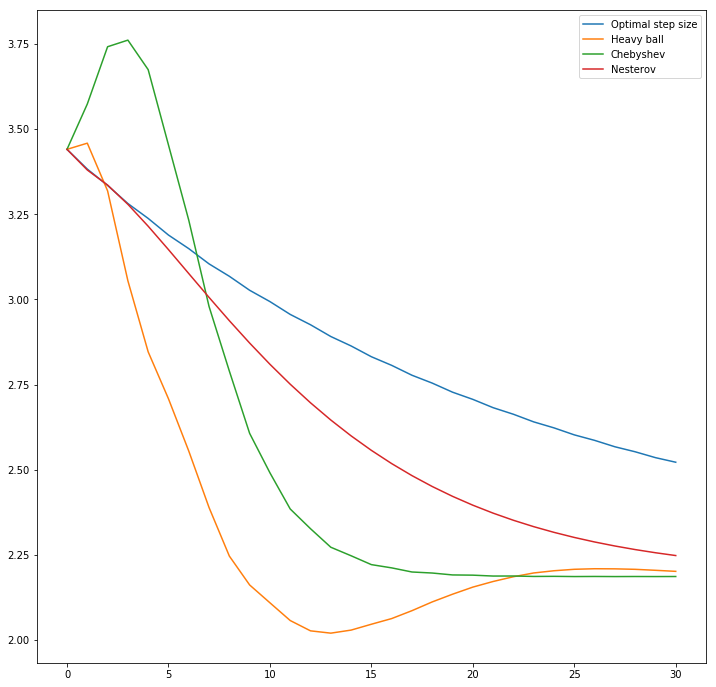

In [151]:
#norm graph
fig, ax = plt.subplots()
u = np.array(traj_opt_step)
ax.plot(range(steps_num + 1), [np.linalg.norm(t) for t in u], label='Optimal step size')
u = np.array(traj_heavy_ball)
ax.plot(range(steps_num + 1), [np.linalg.norm(t) for t in u], label='Heavy ball')
u = np.array(traj_chebyshev)
ax.plot(range(steps_num + 1), [np.linalg.norm(t) for t in u], label='Chebyshev')
u = np.array(traj_nesterov)
ax.plot(range(steps_num + 1), [np.linalg.norm(t) for t in u], label='Nesterov')
plt.legend()
plt.plot()

[]

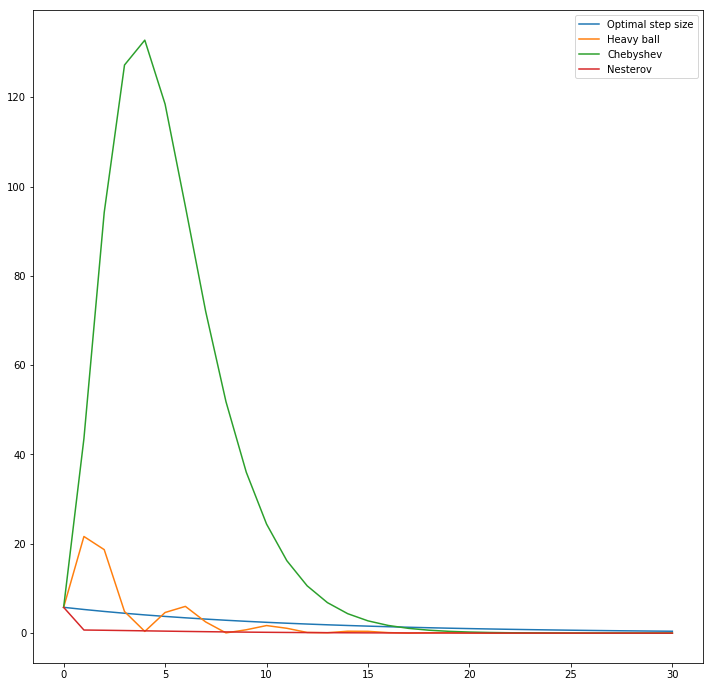

In [152]:
#value graph
fig, ax = plt.subplots()
u = np.array(traj_opt_step)
ax.plot(range(31), [func(t) - func(sol) for t in u], label='Optimal step size')
u = np.array(traj_heavy_ball)
ax.plot(range(31), [func(t) - func(sol) for t in u], label='Heavy ball')
u = np.array(traj_chebyshev)
ax.plot(range(31), [func(t) - func(sol) for t in u], label='Chebyshev')
u = np.array(traj_nesterov)
ax.plot(range(31), [func(t) - func(sol) for t in u], label='Nesterov')
plt.legend()
plt.plot()

In [153]:
#оптимальный шаг черный
#нестеров фиолетовый
#чебышев оранжевый
#шарик синий
base_animation = animate_trajectory(traj_opt_step, traj_nesterov, traj_chebyshev, traj_heavy_ball)
HTML(base_animation.to_html5_video()) 